In [1]:
import numpy as np

In [2]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [37]:
# set configurations
sample_size = 50
nr_sample = 50
num_steps = 20
x_b = np.linspace(0,1,num_steps)


# cv config
test_size = 0.5
cv = 5
cv_config = [test_size, cv]

### Bounded distributions

In [38]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [39]:
kde_df = dem.get_kde(bounded_samples, x_b)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.686630,0.778695,0.823295,0.820988,0.784065,0.731494,0.682712,0.652564,0.648606,0.671053,...,0.772973,0.837745,0.901605,0.955338,0.987058,0.983442,0.933867,0.835795,0.698139,arcsine
1,0.695824,0.832982,0.944239,1.021423,1.060354,1.061920,1.033215,0.986152,0.932817,0.880292,...,0.775493,0.719596,0.667430,0.629950,0.615047,0.619210,0.625543,0.611103,0.559462,arcsine
2,0.806827,0.886465,0.903947,0.868473,0.803253,0.735756,0.688554,0.674105,0.693538,0.738177,...,0.842718,0.875632,0.887944,0.881328,0.858332,0.818300,0.757236,0.671661,0.563403,arcsine


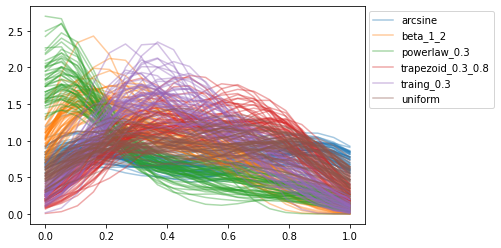

In [40]:
dem.get_kde_plot(kde_df,x_b)

### SVM

In [6]:
sample_size_list = [5, 10, 25, 50, 100, 500, 1000]
num_steps_list = list(np.arange(1,51))

In [7]:
res_svm = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 1)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

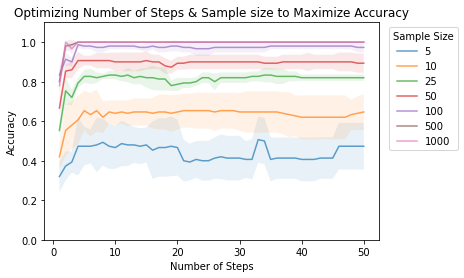

In [8]:
cm.plot_cv_numsteps_samplesize(res_svm)

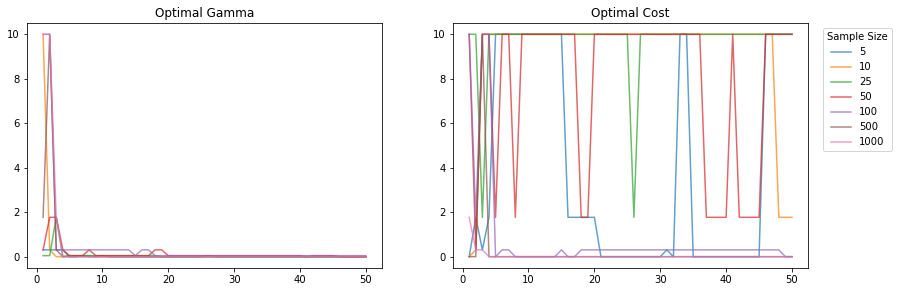

In [9]:
cm.plot_cv_h_params(res_svm)

### Logistic Regression

In [10]:
res_lr = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 2)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

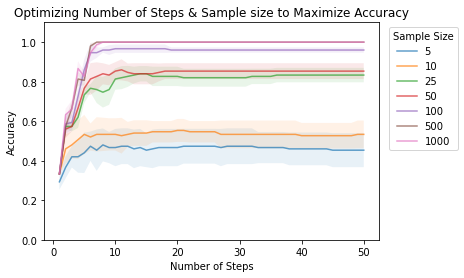

In [11]:
cm.plot_cv_numsteps_samplesize(res_lr)

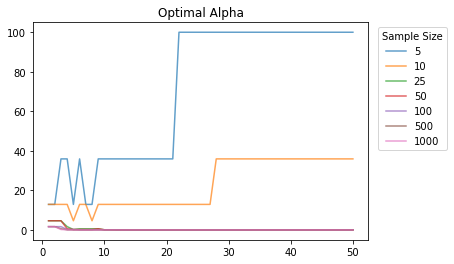

In [12]:
cm.plot_cv_h_params(res_lr)

In [101]:
import json
res_svm['num_steps'] = [int(i) for i in res_svm['num_steps']]
res_lr['num_steps'] = [int(i) for i in res_lr['num_steps']]

with open('results/kde/res_svm_bounded.json', 'w') as f:
    json.dump(res_svm, f)

with open('results/kde/res_lr_bounded.json', 'w') as f:
    json.dump(res_lr, f)

### Heavytail distributions

In [13]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample, sample_size, transform=True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [27]:
perc_95 = np.percentile(heavytail_samples.iloc[:,:-1],95)
x_h = np.linspace(0,perc_95,num_steps)
kde_df = dem.get_kde(heavytail_samples, x_h)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.341617,0.465150,0.558546,0.609279,0.624177,0.617474,0.597330,0.563905,0.516381,0.457429,...,0.322551,0.255835,0.198032,0.154079,0.123058,0.099366,0.078563,0.060866,0.048247,cauchy
1,0.382405,0.486359,0.576007,0.636094,0.655756,0.632127,0.571579,0.487777,0.397190,0.314015,...,0.196982,0.162032,0.136811,0.116748,0.099003,0.082577,0.067684,0.054958,0.044965,cauchy
2,0.397802,0.512569,0.594934,0.639549,0.653714,0.644693,0.612589,0.555142,0.476011,0.386502,...,0.229544,0.178296,0.145549,0.125504,0.111284,0.097500,0.081197,0.062107,0.042527,cauchy


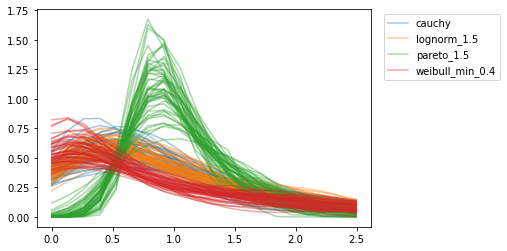

In [28]:
dem.get_kde_plot(kde_df,x_h)

### SVM

In [15]:
res_svm_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 1, transform=True)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

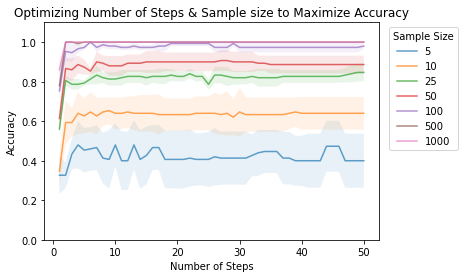

In [16]:
cm.plot_cv_numsteps_samplesize(res_svm_ht)

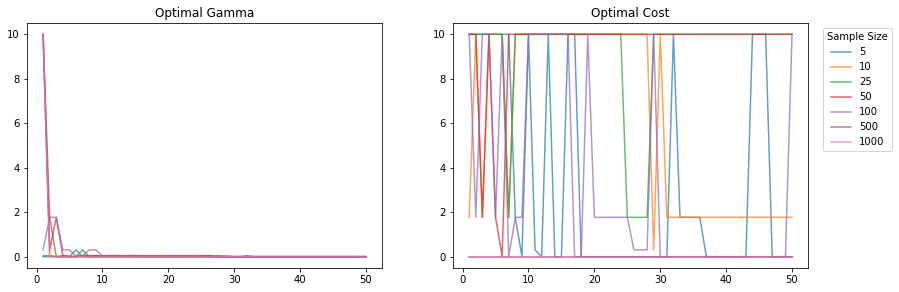

In [17]:
cm.plot_cv_h_params(res_svm_ht)

### Logististic Regression

In [18]:
res_lr_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, heavytail_dists, nr_sample, cv_config, 'kde', 2, transform = True)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

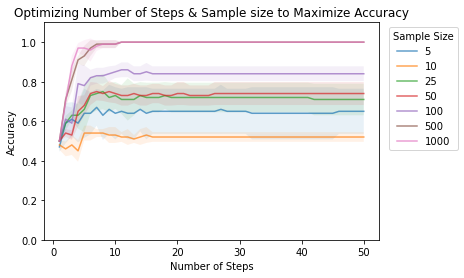

In [19]:
cm.plot_cv_numsteps_samplesize(res_lr_ht)

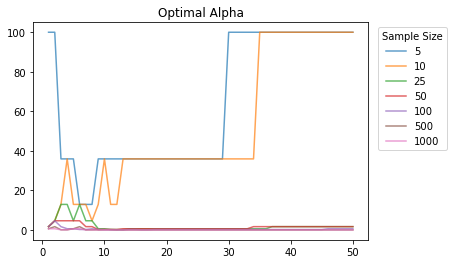

In [20]:
cm.plot_cv_h_params(res_lr_ht)

In [102]:
import json
res_svm_ht['num_steps'] = [int(i) for i in res_svm_ht['num_steps']]
res_lr_ht['num_steps'] = [int(i) for i in res_lr_ht['num_steps']]

with open('results/kde/res_svm_heavytail.json', 'w') as f:
    json.dump(res_svm_ht, f)

with open('results/kde/res_lr_heavytail.json', 'w') as f:
    json.dump(res_lr_ht, f)